# DB Tools 常见问法示例（教学版）

本 notebook 用“常见问法 + 说明 + 自然语言调用示例”的方式讲解订单 DB 工具的用法。
已按功能分区，适合课堂演示或新同学快速上手。


## 0. 环境准备（分步）

### Step 1: 准备依赖与环境
确保项目依赖已安装，并能在本机启动 Python。

### Step 2: 配置环境变量
在项目根目录 `.env` 中配置以下变量：
- `SUPABASE_URL`
- `SUPABASE_SERVICE_ROLE_KEY` 或 `SUPABASE_ANON_KEY`
- `OPENAI_API_KEY`

### Step 3: 载入环境变量
下面的代码会通过 `load_dotenv()` 自动读取 `.env`。

### Step 4: 理解调用方式
本示例用 `app.invoke` 让 LLM 通过自然语言自动选择并调用工具。
你只需要准备好自然语言输入，其余由工具编排完成。


In [16]:
from __future__ import annotations

from dataclasses import asdict
from datetime import datetime
from pathlib import Path
from typing import Any, Dict

from dotenv import load_dotenv
from IPython.display import display, Image
import gradio as gr

# LangChain / LangGraph
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# 业务层：Supabase 操作封装
from services.order_services import (
    create_db_client,
    add_order_to_db,
    cancel_order,
    deliver_order,
    edit_order_from_db,
    finish_order,
    get_order_detail,
    mark_order_paid,
    order_to_text,
)
from services.types import (
    ConflictError,
    ConstraintError,
    NotFoundError,
    TerminalOrderError,
    ValidationError,
)

load_dotenv()


True

## 工具定义

In [17]:
def _order_to_dict(order) -> Dict[str, Any]:
    return asdict(order)

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def create_order_tool(
    *,
    order_id: str,
    user_name: str,
    user_wechat: str,
    sku: str,
    start_at: str,
    end_at: str,
    status: str | None = None,
    buffer_hours: int | None = None,
    locker_code: str | None = None,
) -> Dict[str, Any]:
    """Create an order."""
    try:
        client = create_db_client()
        data = {
            "order_id": order_id,
            "user_name": user_name,
            "user_wechat": user_wechat,
            "sku": sku,
            "start_at": datetime.fromisoformat(start_at),
            "end_at": datetime.fromisoformat(end_at),
        }
        if status is not None:
            data["status"] = status
        if buffer_hours is not None:
            data["buffer_hours"] = buffer_hours
        if locker_code is not None:
            data["locker_code"] = locker_code
        order = add_order_to_db(client=client, **data)
        return {"result": _order_to_dict(order)}
    except (ConflictError, ConstraintError, ValidationError, ValueError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def get_order_tool(*, order_id: str) -> Dict[str, Any]:
    """Get order detail."""
    try:
        client = create_db_client()
        order = get_order_detail(order_id, client=client)
        return {"result": order_to_text(order)}
    except NotFoundError as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def update_order_tool(*, order_id: str, patch: Dict[str, Any]) -> Dict[str, Any]:
    """Update order by patch."""
    try:
        client = create_db_client()
        order = edit_order_from_db(order_id, patch=patch, client=client)
        return {"result": _order_to_dict(order)}
    except (ConflictError, ConstraintError, ValidationError, NotFoundError, TerminalOrderError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def cancel_order_tool(*, order_id: str, hard_delete: bool = False) -> Dict[str, Any]:
    """Cancel order."""
    try:
        client = create_db_client()
        order = cancel_order(order_id, hard_delete=hard_delete, client=client)
        return {"result": _order_to_dict(order)}
    except (NotFoundError, ValidationError, TerminalOrderError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def mark_paid_tool(*, order_id: str) -> Dict[str, Any]:
    """Mark order paid."""
    try:
        client = create_db_client()
        order = mark_order_paid(order_id, client=client)
        return {"result": _order_to_dict(order)}
    except (NotFoundError, ValidationError, TerminalOrderError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def deliver_order_tool(*, order_id: str, locker_code: str) -> Dict[str, Any]:
    """Deliver order with locker_code."""
    try:
        client = create_db_client()
        order = deliver_order(order_id, locker_code=locker_code, client=client)
        return {"result": _order_to_dict(order)}
    except (NotFoundError, ValidationError, ConstraintError, TerminalOrderError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}

@tool
# Keyword-only args keep tool schema explicit for the LLM.
def finish_order_tool(*, order_id: str) -> Dict[str, Any]:
    """Finish order."""
    try:
        client = create_db_client()
        order = finish_order(order_id, client=client)
        return {"result": _order_to_dict(order)}
    except (NotFoundError, ValidationError, TerminalOrderError) as exc:
        return {"error": f"{exc.__class__.__name__}: {exc}"}


### RAG 规则工具

规则文件放在 `agent/rules/rental_rules.md`，你可以直接编辑该文件。
这里用 `langchain_text_splitters` 的 `MarkdownHeaderTextSplitter` 保留层级结构元信息，
并将标题层级拼接进片段以增强检索能力。
向量检索使用本地 Qdrant，Embedding 使用 BGE-M3。
如未安装依赖：`pip install langchain-qdrant qdrant-client langchain-community langchain-text-splitters sentence-transformers`。


In [18]:
RULES_PATH = Path("agent/rules/rental_rules.md")


HEADERS_TO_SPLIT_ON = [
    ("#", "h1"),
    ("##", "h2"),
    ("###", "h3"),
    ("####", "h4"),
]


# 用 MarkdownHeaderTextSplitter 保留层级结构元信息
_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=HEADERS_TO_SPLIT_ON)



def _load_rule_chunks(path: Path) -> list[str]:
    if not path.exists():
        return []
    text = path.read_text(encoding="utf-8")
    docs = _splitter.split_text(text)
    chunks: list[str] = []
    for d in docs:
        # 将标题层级拼接到片段前部，增强检索语义
        header_parts = [
            d.metadata.get("h1"),
            d.metadata.get("h2"),
            d.metadata.get("h3"),
            d.metadata.get("h4"),
        ]
        header = " > ".join([h for h in header_parts if h])
        if header:
            chunks.append(f"{header}\n{d.page_content}".strip())
        else:
            chunks.append(d.page_content.strip())
    return [c for c in chunks if c]


# Qdrant（本地） + BGE-M3 Embeddings
_QDRANT_URL = "http://localhost:6333"
_COLLECTION = "rental_rules"

_RULE_DOCS = _load_rule_chunks(RULES_PATH)

# BGE-M3 需要 query_instruction=""
_embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
    query_instruction="",
)

# NOTE: 本地开发常用重建集合；如需保留向量可把 _RECREATE 设为 False
_RECREATE = False

_qdrant = (
    QdrantVectorStore.from_texts(
        texts=_RULE_DOCS,
        embedding=_embeddings,
        url=_QDRANT_URL,
        collection_name=_COLLECTION,
        force_recreate=_RECREATE,
    )
    if _RULE_DOCS
    else None
)



def _retrieve_rule_snippets(query: str, k: int = 3) -> list[str]:
    if not _RULE_DOCS or _qdrant is None:
        return []
    results = _qdrant.similarity_search(query, k=k)
    return [r.page_content for r in results]


@tool
def rag_rules_tool(*, question: str) -> Dict[str, Any]:
    """基于本地规则文件回答客户的规则/流程/计费/押金等问题。"""
    snippets = _retrieve_rule_snippets(question, k=3)
    if not snippets:
        return {"result": "规则库未命中相关条目。"}
    ctx = "\n".join(f"- {s}" for s in snippets)
    return {"result": f"在文件中查到的相关规则如下：\n{ctx}\n\n"}


## 工具绑定与图编排

In [19]:
TOOLS = [
    rag_rules_tool,
    create_order_tool,
    get_order_tool,
    update_order_tool,
    cancel_order_tool,
    mark_paid_tool,
    deliver_order_tool,
    finish_order_tool,
]

llm = init_chat_model(
    model="gpt-5-nano",
    temperature=0,
).bind_tools(TOOLS)

def agent_node(state: MessagesState) -> Dict[str, Any]:
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

tool_node = ToolNode(TOOLS)

graph = StateGraph(MessagesState)
graph.add_node("agent", agent_node)
graph.add_node("tools", tool_node)
graph.set_entry_point("agent")
graph.add_conditional_edges("agent", tools_condition, {"tools": "tools", "__end__": "__end__"})
graph.add_edge("tools", "agent")

checkpointer = MemorySaver()

app = graph.compile(checkpointer=checkpointer)

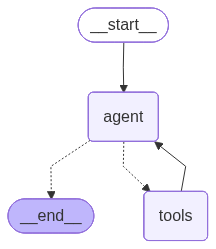

In [20]:

display(Image(app.get_graph().draw_mermaid_png()))


## 0. 规则问答（RAG）

适用场景：客户咨询规则、押金、计费、清洗、尺码、流程等。
该问题会优先走 `rag_rules_tool`，不会访问订单 DB。

常见问法：
- “押金怎么退？” → `rag_rules_tool`
- “超期怎么计费？” → `rag_rules_tool`


In [ ]:
# 自然语言触发 RAG 规则问答
result = app.invoke({
    "messages": [
        HumanMessage(content="怎么租衣服？")
    ]
})


for m in result["messages"]:
    m.pretty_print()


## 1. 订单创建（Create）

适用场景：新用户下单，或客服手动录入订单。
重点字段：`order_id`（唯一）、`start_at`/`end_at`（ISO 时间字符串）、`sku`（商品编码）。

常见问法：
- “帮我创建一个新的租赁订单。” → `create_order_tool`
- “新增订单，状态先设为 pending。” → `create_order_tool`


In [34]:
# 自然语言触发创建订单
result = app.invoke({
    "messages": [
        HumanMessage(content=(
            "创建订单：订单号 ORD-10001，用户张三，微信号 zhangsan_001，"
            "SKU 是 WHITE_M，开始时间 2025-01-10 10:00，"
            "结束时间 2025-01-12 18:00，状态 reserved，预留缓冲 2 小时。"
        ))
    ]
})


for m in result["messages"]:
    m.pretty_print()


================================ Human Message =================================

创建订单：订单号 ORD-10001，用户张三，微信号 zhangsan_001，SKU 是 WHITE_M，开始时间 2025-01-10 10:00，结束时间 2025-01-12 18:00，状态 reserved，预留缓冲 2 小时。
================================== Ai Message ==================================
Tool Calls:
  create_order_tool (call_Mmlz1RotHo7ff6nHkbCAjQgR)
 Call ID: call_Mmlz1RotHo7ff6nHkbCAjQgR
  Args:
    order_id: ORD-10001
    user_name: 张三
    user_wechat: zhangsan_001
    sku: WHITE_M
    start_at: 2025-01-10 10:00
    end_at: 2025-01-12 18:00
    status: reserved
    buffer_hours: 2
    locker_code: None
================================= Tool Message =================================
Name: create_order_tool

{'result': {'order_id': 'ORD-10001', 'user_name': '张三', 'user_wechat': 'zhangsan_001', 'sku': 'WHITE_M', 'start_at_iso': datetime.datetime(2025, 1, 10, 10, 0, tzinfo=datetime.timezone.utc), 'end_at_iso': datetime.datetime(2025, 1, 12, 18, 0, tzinfo=datetime.timezone.utc), 'buffer_hour

## 2. 订单查询（Read）

适用场景：客户询问订单详情，或运营核对订单信息。
返回值：已格式化的订单文本（便于直接展示给用户）。

常见问法：
- “查询订单 ORD-10001 的详情。” → `get_order_tool`
- “给我看下这笔订单的当前状态。” → `get_order_tool`


In [ ]:
# 自然语言触发查询订单
result = app.invoke({
    "messages": [
        HumanMessage(content="查询订单 ORD-10001 的详情")
    ]
})

for m in result["messages"]:
    m.pretty_print()


## 3. 订单修改（Update）

适用场景：用户改期、修改时段或补充字段信息。
入参是 `patch` 字典，字段名与订单字段一致。

常见问法：
- “把订单的结束时间改成明天下午 6 点。” → `update_order_tool`
- “更新订单的备注/字段。” → `update_order_tool`


In [ ]:
# 自然语言触发更新订单
result = app.invoke({
    "messages": [
        HumanMessage(content=(
            "把订单 ORD-10001 的结束时间改为 2025-01-15 18:00"
        ))
    ]
})


for m in result["messages"]:
    m.pretty_print()


## 4. 订单取消（Cancel）

适用场景：用户主动取消或客服撤销订单。
`hard_delete=False` 为软取消（保留记录），`True` 会尝试删除记录。

常见问法：
- “取消这笔订单。” → `cancel_order_tool`
- “把这笔订单彻底删除。” → `cancel_order_tool`（`hard_delete=True`）


In [ ]:
# 自然语言触发取消订单
result = app.invoke({
    "messages": [
        HumanMessage(content="取消订单 ORD-10001")
    ]
})


for m in result["messages"]:
    m.pretty_print()


## 5. 付款状态（Payment）

适用场景：确认收款后将订单标记为已付款。
该操作会触发业务状态流转（若订单已终止会报错）。

常见问法：
- “这笔订单已付款。” → `mark_paid_tool`
- “把订单状态改为已付款。” → `mark_paid_tool`


In [ ]:
# 自然语言触发标记已付款
result = app.invoke({
    "messages": [
        HumanMessage(content="订单 ORD-10001 已付款，请更新状态")
    ]
})


for m in result["messages"]:
    m.pretty_print()


## 6. 发货交付（Delivery）

适用场景：订单已准备好并发货，需要填写柜机码或取件码。
`locker_code` 为必填字段，用于用户取件。

常见问法：
- “请发货并填入柜机码。” → `deliver_order_tool`
- “订单已发出，柜机码是 A1-09。” → `deliver_order_tool`


In [ ]:
# 自然语言触发发货交付
result = app.invoke({
    "messages": [
        HumanMessage(content="订单 ORD-10001 已发货，柜机码是 A1-09")
    ]
})


for m in result["messages"]:
    m.pretty_print()


## 7. 完成订单（Finish）

适用场景：用户确认归还/租期结束，订单完成闭环。
完成后通常不可再修改关键字段。

常见问法：
- “订单已完成。” → `finish_order_tool`
- “可以结束这笔订单了。” → `finish_order_tool`


In [ ]:
# 自然语言触发完成订单
messages = app.invoke({
    "messages": [
        HumanMessage(content="订单 ORD-10001 已完成，请结束流程")
    ]
})

for m in messages["messages"]:
    m.pretty_print()


## 8. Gradio 简易前端（Human-in-the-loop）

用于让用户与 graph 持续对话，完成下单/查询/规则问答等任务。


In [25]:
import uuid


def _ensure_thread_id(thread_id: str | None) -> str:
    if thread_id:
        return thread_id
    return f"thread-{uuid.uuid4().hex}"


def _load_chat(thread_id: str | None):
    thread_id = _ensure_thread_id(thread_id)
    history: list[dict[str, str]] = []
    try:
        state = app.get_state({"configurable": {"thread_id": thread_id}})
        messages = state.values.get("messages", []) if state else []
        for m in messages:
            if isinstance(m, HumanMessage):
                history.append({"role": "user", "content": m.content})
            elif isinstance(m, AIMessage):
                history.append({"role": "assistant", "content": m.content})
    except Exception:
        pass
    return history, thread_id


def _chat(message: str, history: list[dict[str, str]], thread_id: str | None):
    thread_id = _ensure_thread_id(thread_id)
    result = app.invoke(
        {"messages": [HumanMessage(content=message)]},
        config={"configurable": {"thread_id": thread_id}},
    )
    ai_msg = result["messages"][-1]
    content = ai_msg.content if isinstance(ai_msg, AIMessage) else str(ai_msg)
    history = history + [
        {"role": "user", "content": message},
        {"role": "assistant", "content": content},
    ]
    return "", history, thread_id



def _new_chat():
    thread_id = _ensure_thread_id(None)
    return [], thread_id


with gr.Blocks(title="Rental Agent") as demo:
    gr.Markdown("""# Rental Agent - 基于 LangGraph 的订单/规则助手。""")
    browser_state = gr.BrowserState(storage_key="rental_thread_id")
    chatbot = gr.Chatbot(label="对话")
    msg = gr.Textbox(label="输入", placeholder="输入问题或订单指令")
    send = gr.Button("发送")
    new_chat = gr.Button("新对话")

    demo.load(_load_chat, inputs=browser_state, outputs=[chatbot, browser_state])
    msg.submit(_chat, inputs=[msg, chatbot, browser_state], outputs=[msg, chatbot, browser_state])
    send.click(_chat, inputs=[msg, chatbot, browser_state], outputs=[msg, chatbot, browser_state])
    new_chat.click(_new_chat, inputs=None, outputs=[chatbot, browser_state])


demo.launch()



* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
